In [1]:
# Data Processing With PySpark SQL

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, mean,hour, when, to_timestamp, round
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder \
              .appName("DataProcessing") \
              .getOrCreate()

In [3]:
df = spark.read.csv(".\data\Taxi_Trips_2020.csv", header=True, inferSchema=True)

In [4]:
df.show(5)

+--------------------+--------------------+--------------------+--------------------+------------+----------+-------------------+--------------------+---------------------+----------------------+----+----+-----+------+----------+------------+--------------------+------------------------+-------------------------+------------------------+-------------------------+--------------------------+--------------------------+
|             Trip ID|             Taxi ID|Trip Start Timestamp|  Trip End Timestamp|Trip Seconds|Trip Miles|Pickup Census Tract|Dropoff Census Tract|Pickup Community Area|Dropoff Community Area|Fare|Tips|Tolls|Extras|Trip Total|Payment Type|             Company|Pickup Centroid Latitude|Pickup Centroid Longitude|Pickup Centroid Location|Dropoff Centroid Latitude|Dropoff Centroid Longitude|Dropoff Centroid  Location|
+--------------------+--------------------+--------------------+--------------------+------------+----------+-------------------+--------------------+----------

In [5]:
df.describe().show()

+-------+--------------------+--------------------+--------------------+--------------------+-----------------+------------------+--------------------+--------------------+---------------------+----------------------+------------------+------------------+--------------------+-----------------+-----------------+------------+--------------------+------------------------+-------------------------+------------------------+-------------------------+--------------------------+--------------------------+
|summary|             Trip ID|             Taxi ID|Trip Start Timestamp|  Trip End Timestamp|     Trip Seconds|        Trip Miles| Pickup Census Tract|Dropoff Census Tract|Pickup Community Area|Dropoff Community Area|              Fare|              Tips|               Tolls|           Extras|       Trip Total|Payment Type|             Company|Pickup Centroid Latitude|Pickup Centroid Longitude|Pickup Centroid Location|Dropoff Centroid Latitude|Dropoff Centroid Longitude|Dropoff Centroid  Loca

In [6]:
df.printSchema()

root
 |-- Trip ID: string (nullable = true)
 |-- Taxi ID: string (nullable = true)
 |-- Trip Start Timestamp: string (nullable = true)
 |-- Trip End Timestamp: string (nullable = true)
 |-- Trip Seconds: integer (nullable = true)
 |-- Trip Miles: double (nullable = true)
 |-- Pickup Census Tract: long (nullable = true)
 |-- Dropoff Census Tract: long (nullable = true)
 |-- Pickup Community Area: integer (nullable = true)
 |-- Dropoff Community Area: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Tips: double (nullable = true)
 |-- Tolls: double (nullable = true)
 |-- Extras: double (nullable = true)
 |-- Trip Total: double (nullable = true)
 |-- Payment Type: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Pickup Centroid Latitude: double (nullable = true)
 |-- Pickup Centroid Longitude: double (nullable = true)
 |-- Pickup Centroid Location: string (nullable = true)
 |-- Dropoff Centroid Latitude: double (nullable = true)
 |-- Dropoff Centroid 

<Figure size 1000x600 with 0 Axes>

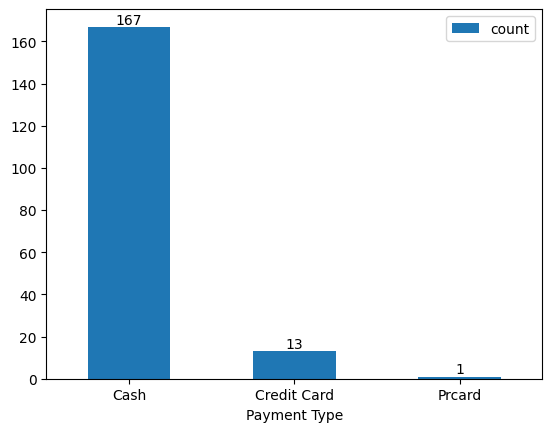

In [8]:
# df.select("Payment Type","Trip Total","Fare").filter(df["Trip Total"]==0).show()
trip_total_null = df.filter(df["Trip Total"].isNull()).groupBy("Payment Type").count()

# Convertissez le dataframe Spark en DataFrame Pandas pour la visualisation
trip_total_null_pd = trip_total_null.toPandas()

plt.figure(figsize=(10, 6))
ax = trip_total_null_pd.plot(kind="bar", x="Payment Type", y="count")

for i, v in enumerate(trip_total_null_pd["count"]):
    ax.text(i, v, str(v), ha="center", va="bottom")

plt.xticks(rotation=0)
plt.show()

In [9]:
avg_trip_total = df.agg(mean("Trip Total")).collect()[0][0]

df = df.withColumn("Trip Total", when(df["Trip Total"].isNull(), avg_trip_total).otherwise(df["Trip Total"]))
df = df.withColumn("Tips", when(df["Tips"].isNull(), 0).otherwise(df["Tips"]))

#Now we have 2812332 rows with no NULL value.

In [10]:
df = df.withColumn("Period",
                   when(hour(col("Trip Start Timestamp")).between(0, 11), "Morning")
                   .when(hour(col("Trip Start Timestamp")).between(12, 16), "Afternoon")
                   .otherwise("Night"))

# New columns
df = df.withColumn("Trip Minute", round(col("Trip Seconds") / 60, 2))
df = df.withColumn("Trip Kilometres", round(col("Trip Miles") * 1.609,2))

columns_to_drop = ["Trip Seconds", "Trip Miles"]
df = df.drop(*columns_to_drop)

df.show()

+--------------------+--------------------+--------------------+----+----------+------------+------------------------+-------------------------+-------------------------+--------------------------+-------+-----------+---------------+
|             Trip ID|             Taxi ID|Trip Start Timestamp|Tips|Trip Total|Payment Type|Pickup Centroid Latitude|Pickup Centroid Longitude|Dropoff Centroid Latitude|Dropoff Centroid Longitude| Period|Trip Minute|Trip Kilometres|
+--------------------+--------------------+--------------------+----+----------+------------+------------------------+-------------------------+-------------------------+--------------------------+-------+-----------+---------------+
|031a4d882fb3315a4...|aabecb47e958f9986...| 2020-01-01 00:00:00|2.55|      14.8| Credit Card|            41.899602111|            -87.633308037|             41.899602111|             -87.633308037|Morning|       12.0|           1.13|
|3c416c246829dfb3f...|ba106251fbb2b5217...| 2020-01-01 00:00:00|

In [11]:
df.printSchema()

root
 |-- Trip ID: string (nullable = true)
 |-- Taxi ID: string (nullable = true)
 |-- Trip Start Timestamp: timestamp (nullable = true)
 |-- Tips: double (nullable = true)
 |-- Trip Total: double (nullable = true)
 |-- Payment Type: string (nullable = true)
 |-- Pickup Centroid Latitude: double (nullable = true)
 |-- Pickup Centroid Longitude: double (nullable = true)
 |-- Dropoff Centroid Latitude: double (nullable = true)
 |-- Dropoff Centroid Longitude: double (nullable = true)
 |-- Period: string (nullable = false)
 |-- Trip Minute: double (nullable = true)
 |-- Trip Kilometres: double (nullable = true)



In [ ]:
df.write.csv("./data/process_data.csv", header=True)